<a href="https://colab.research.google.com/github/blackJJW/DL/blob/main/self_study_DL/chapter8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08-2 합성곱 신경망을 사용한 이미지 분류

## 패션 MNIST 데이터 불러오기

- 완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 일렬로 펼쳐야함
- 이 작업을 위해서는 넘파이 reshape() 메서드를 사용하거나 Flatten 클래스를 사용
- 합성곱 신경망은 2차원 이미지를 그대로 사용하기 때문에 이렇게 일렬로 펼치지 않음

- 입력 이미지는 항상 깊이(채널) 차원이 있어야함
- 흑백 이미지의 경우 채널 차원이 없는 2차원 배열이지만 Conv2D 층을 사용하기 위해 마지막에 이 채널 차원을 추가해야 함
- 넘파이 reshape() 메서드를 사용해 첮체 배열 차원을 그대로 유지하면서 마지막에 차원을 간단히 추가 가능

In [21]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, 
                                                                      train_target, 
                                                                      test_size = 0.2, 
                                                                      random_state = 42)

- (48000, 28, 28) 크기인 train_input이 (48000, 28, 28, 1) 크기인 train_scaled가 됨

## 합성곱 신경망 만들기

- 합성곱 신경망의 구조는 합성곱 층으로 이미지에서 특징을 감지한 후 밀집층으로 클래스에 따른 분류 확률을 계산

- 케라스의 Sequential 클래스를 사요해 순서대로 이 구조를 정의
  - Sequential 클래스의 객체를 만들고 첫 번째 합성곱 층인 Conv2D를 추가
  - add() 메서드를 사용해 층을 하나씩 차례대로 추가


In [22]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', 
                              padding='same', input_shape=(28, 28, 1)))

- 이 합성곱 층은 32개의 필터를 사용
- 커널의 크기는 (3, 3)
- 렐루 함수와 세임 패딩을 사용

- 풀링 층을 추가
- keras.layers 패키지 아래 MaxPooling2D와 AveragePooling 클래스를 제공
- 전형적인 풀링 크기인 (2, 2) 풀링을 사용
- Conv2D 클래스의 kernel_size처럼 가로세로 크기가 같으면 정수 하나로 지정 가능

In [23]:
model.add(keras.layers.MaxPooling2D(2))

- 패션 MNIST 이미지가 (28, 28) 크기에 세임 패딩을 적용했기 때문에 합성곱 층에서 출력된 큭성 맵의 가로세로 크기는 입력과 동일
- (2, 2) 풀링을 적용했으므로 특성 맵의 크기는 절반으로 줄어들어듬
- 합성곱 층에서 32개의 필터를 사용했기 때문에 이 특성 맵의 깊이는 32가 됨
- 따라서 최대 풀링을 통과한 특성 맵의 크기는 (14, 14, 32)가 됨

- 첫 번째 합성곱-풀링 층 다음에 두 번째 합성곱-풀링 층을 추가
- 두 번째 합성곱-풀링 층은 첫 번째와 동일
  - 필터의 개수는 64개로 늘림

In [24]:
model.add(keras.layers.Conv2D(64, kernel_size=3, 
                              activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

- 첫 번째 합성곱-풀링 층과 마찬가지로 이 합성곱 층은 세임 패딩을 사용
  - 따라서 입력의 가로 세로 크기를 줄이지 않음
  - 이어지는 풀링 층에서 이 크기를 절반으로 줄임
  - 64개의 필터를 사용했으므로 최종적으로 만들어지는 특성 맵의 크기는 (7, 7, 64)가 될 것임

- 3차원 특성 맵을 일렬로 펼칠 차례
  - 이렇게 하는 이유는 마지막에 10개의 뉴런을 가진(밀집) 출력층에서 확률을 계산하기 때문
- 여기에서는 특성 맵을 일렬로 펼쳐서 바로 출력층에 전달하지 않고 중간에 하나의 밀집 은닉층을 하나 더 둔다.
  - 즉 Flatten 클래스 다음에 Dense 은닉층, 마지막으로 Dense 출력층의 순서대로 구성

In [25]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

- 은닉층과 출력층 사이에 드롭아웃을 넣음
- 드롭아웃 층이 은닉층의 과대적합을 막아 성능을 조금 더 개선
- 은닉층은 100개의 뉴런을 사용하고 활성화 함수는 합성곱 층과 마찬가지로 렐루 함수를 사용
- 패션 MNIST 데이터셋은 클래스 10개를 분류하는 다중 분류 문제이므로 마지막 층의 활성화 함수는 소프트맥스를 사용

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

- 출력 결과를 보면 합성곱 층과 풀링 층의 효과가 잘 나타남
- 첫 번째 합성곱 층을 통과하면서 특성 맵의 깊이는 32가 되고 두 번째 합성곱에서 특성 맵의 크기가 64로 늘어남
- 반면 특성 맵의 가로세로 크기는 첫 번째 풀링 층에서 절바으로 줄어들고 두 번째 풀링층에서 다시 절반으로 더 줄어듬
- 최종 특성 맵의 크기는 (7, 7, 64)

- 모델 파라미터의 개수를 계산
  - 첫 번째 합성곱 층은 32개의 필터를 가지고 있고 크기가 (3, 3), 깊이가 1
    - 필터마다 하나의 절편이 존재
  - 따라서 총 $3 \times 3 \times 3 \times 1 \times 32 + 32 = 320$개의 파라미터가 존재
  - 두 번째 합성곱 층은 64개의 필터를 사용하고 있고 크기가 (3, 3), 깊이가 32
    - 필터마다 하나의 절편
  - 따라서 총 $3 \times 3 \times 3 \times 1 \times 64 + 64 = 18,496$개의 파라미터가 존재

- Flatten 클래스에서 (7, 7, 64) 크기의 특성 맵을 1차원 배열로 펼치면 (3136,) 크기의 배열이 됨
  - 이를 100개의 뉴런과 완전히 연결해야 하므로 은닉층의 모델 파라미터 개수는 $3,136 \times 100 + 100 = 313,700$개
  - 마지막 출력층의 모델 파라미터 개수는 1,010개

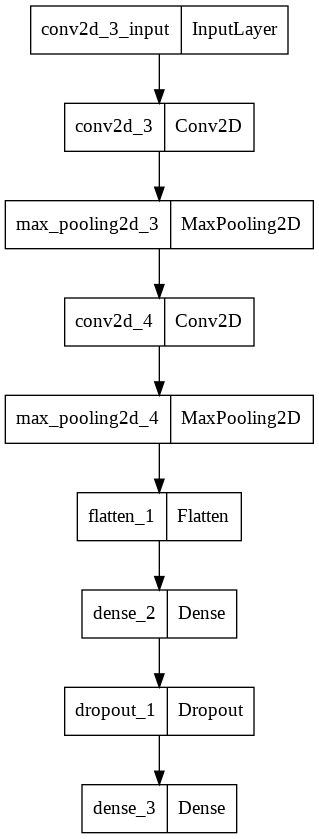

In [27]:
keras.utils.plot_model(model)

- 네모 상자 안의 내용 중 콜론 왼쪽에는 층의 이름이 쓰여 있고 오른쪽에는 클래스가 나타남
- 맨처음에 나오는 InputLayer 클래스는 케라스가 자동으로 추가해 주는 것으로 입력층의 역할을 함
- 이 입력층은 첫 번째 Conv2D 클래스에 추가한 input_shape 매개변수를 사용

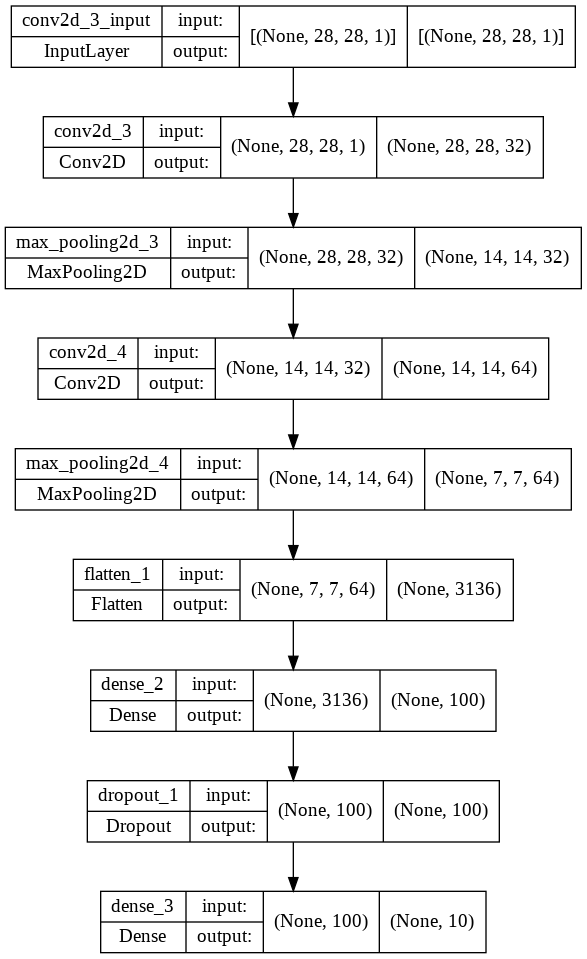

In [28]:
keras.utils.plot_model(model, show_shapes=True)

## 모델 컴파일과 훈련

- 케라스 API의 장점은 딥러닝 모델의 종류나 구성 방식에 상관없이 컴파일과 훈련 과정이 같다는 점

- Adam 옵티마이저를 사용하고 ModelCheckpoint 콜백과 EarlyStopping 콜백을 함께 사용해서 조기 종료 기법을 구현

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, 
                    validation_data = (val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.5078 - accuracy: 0.8197 - val_loss: 0.3443 - val_accuracy: 0.8709
Epoch 2/20
1500/1500 [==============================] - 14s 10ms/step - loss: 0.3377 - accuracy: 0.8796 - val_loss: 0.2956 - val_accuracy: 0.8921
Epoch 3/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2889 - accuracy: 0.8955 - val_loss: 0.2614 - val_accuracy: 0.9022
Epoch 4/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2565 - accuracy: 0.9076 - val_loss: 0.2335 - val_accuracy: 0.9153
Epoch 5/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2331 - accuracy: 0.9142 - val_loss: 0.2302 - val_accuracy: 0.9163
Epoch 6/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2147 - accuracy: 0.9210 - val_loss: 0.2170 - val_accuracy: 0.9210
Epoch 7/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1981 - accuracy: 0.9257 - val_loss: 0.2211 - val_a

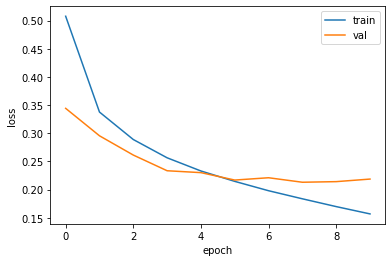

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 검증 세트에 대한 손실이 점차 감소하다가 정체되기 시작하고 훈련 세트에 대한 손실은 점점 더 낮아짐

- EarlyStopping 클래스에서 restore_best_weights 매개변수를 True로 지정해씅므로 현재 model 객체가 최적의 모델 파라미터로 복원되어 있음
  - ModelCheckpoint 콜백이 저장한 best-cnn-model.h5 파일을 다시 읽을 필요가 없음

In [31]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 4ms/step - loss: 0.2131 - accuracy: 0.9243


[0.2131173461675644, 0.9242500066757202]

- predict() 메서드를 사용해 훈련된 모델을 사용하여 새로운 데이터에 대해 예측을 생성
  - 여기에서는 편의상 검증 세트의 첫 번째 샘플을 처음 본 이미지라 가정
  - 맷플롯립에서는 흑백 이미지의 깊이 차원은 없음.
  - 따라서 (28, 28, 1) 크기를 (28, 28)로 바꾸어 출력

- 첫 번째 샘플 이미지를 먼저 확인

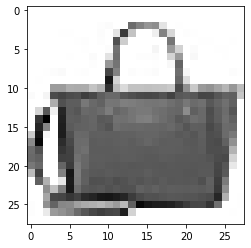

In [32]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [33]:
preds = model.predict(val_scaled[0:1])
print(preds)

[[2.6627848e-18 2.5397247e-24 1.3919028e-18 3.3397655e-18 3.2863645e-21
  2.4139814e-18 1.6696805e-19 4.0321197e-20 1.0000000e+00 9.6514697e-20]]


> 슬라이싱을 사용한 이유
- 케라스의 fit(), predict(), evaluate() 메서드는 모두 입력의 첫 번째 차원이 배치 차원일 것을 기대
- 따라서 샘플 하나를 전달할 때 (28, 28, 1)이 아니라 (1, 28, 28, 1) 크기를 전달해야함
- 배열 슬라이싱은 인덱싱과 다르게 선택된 원소가 하나이더라도 전체 차원이 유지되어 (1, 28, 28, 1)의 크기를 만듬

- 출력 결과를 보면 9번째 결과 값이 1에 가까움
  - 아홉 번째 클래스라고 강하게 주장하고 있는 것임

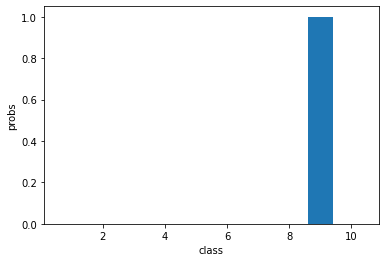

In [34]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('probs')
plt.show()

In [35]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', 
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [36]:
import numpy as np
print(classes[np.argmax(preds)])

가방


- 이 모델을 실전에 투입했을 때 얻을 수 있는 예상 성능
- 훈련 세트와 검증 세트에서 했던 것러럼 픽셀값의 범위를 0~1 사이로 바꾸고 이미지 크기를 (28, 28)에서 (28, 28, 1)로 바꿈

In [37]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [38]:
model.evaluate(test_scaled,test_target)

313/313 [==============================] - 2s 6ms/step - loss: 0.2338 - accuracy: 0.9178


[0.23375551402568817, 0.9178000092506409]

- 약 91%의 성능을 기대

## 마무리

- 핵심 패키지와 함수
> TensorFlow
  - Conv2D : 입력의 너비와 높이 방향의 합성곱 연산을 구현한 클래스
    - 첫 번째 매개변수 : 합성곱 필터의 개수
    - kernel_size : 필터의 커널 크기 지정
      - 가로세로 크기가 같은 경우 정수 하나로, 다른 경우 정수의 튜플로 지정가능
      - 일반적으로 커널의 가로세로 크기는 동일
      - 커널의 깊이는 입력의 깊이와 동일하기 때문에 따로 지정하지 않음
    - strides : 필터의 이동 간격을 지정
      - 가로세로 크기가 같은 경우 정수 하나로, 다른 경우 정수의 튜플로 지정가능
      - 일반적으로 가로세로 크기는 동일
      - 기본값 = 1
    - padding : 입력의 패딩 타입 지정
      - 기본값 'valid'는 패딩을 하지 않음
      - 'same' : 합성곱 층의 출력의 가로세로 크기를 입력과 동일하게 맞추도록 입력에 패딩을 추가
    - activation : 합성곱 층에 적용할 활성화 함수를 적용
  - MaxPooling2D : 입력의 너비와 높이를 줄이는 풀링 연산을 구현한 클래스
    - 첫 번째 매개변수는 풀링의 크기를 지정
      - 가로세로 크기가 같은 경우 정수 하나로, 다른 경우 정수의 튜플로 지정가능
      - 일반적으로 가로세로 크기는 동일
    - strides : 풀링의 이동 간격을 지정
      - 기본값은 풀링의 크기와 동일
        - 입력 위를 겹쳐서 풀링하지 않음
    - padding : 입력의 패딩 타입 지정
      - 기본값 'valid'는 패딩을 하지 않음
      - 'same' : 합성곱 층의 출력의 가로세로 크기를 입력과 동일하게 맞추도록 입력에 패딩을 추가
  - plot_model() : 케라스 모델 구조를 주피터 노트북에 그리거나 파일로 저장
    - 첫 번째 매개변수에 케라스 모델 객체를 전달
    - to_file : 파일 이름을 지정하면 그림을 파일로 저장
    - show_shapes : True로 지정하면 층의 입력, 출력 크기를 표시
      - 기본값은 False
    - show_layer_names : True로 지정하면 층 이름을 출력
      - 기본값 : True   
   


   

> matplotlib
- bar() : 막대그래프를 출력
  - 첫 번째 매개변수에 x축의 값을 리스트나 넘파이 배열로 전달
  - 두 번째 매개변수에 막대의 y축 값을 리스트나 넘파이 배열로 전달
  - width : 막대의 두께를 지정
    - 기본값 : 0.8

> 